In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import tushare as ts
import scipy as sp
tk = pd.read_csv('tk.csv')
ts.set_token(tk.iloc[0])

In [2]:
pro = ts.pro_api()
df1 = pro.daily(ts_code = '000002.SZ', start_date = '20170901', end_date = '20181011')

In [6]:
# T-检验
sp.random.seed(1235)
x=sp.stats.norm.rvs(size=10000)
# sp.stats.norm.rvs产生一个连续的正态分布函数
print("T-value P-value (two-tail)")
print(sp.stats.ttest_1samp(x,0.5))
print(sp.stats.ttest_1samp(x,0))
# 第一个检验的零假设是均值为0.5，第二个检验的零假设是均值为0，根据检验结果，第一个检验结果推翻了零假设，第二个检验结果接受了零假设

T-value P-value (two-tail)
Ttest_1sampResult(statistic=-49.763471231428966, pvalue=0.0)
Ttest_1sampResult(statistic=-0.2631032192508302, pvalue=0.7924764437516486)


In [21]:
close_1 = df1.close.values

ret_1 = (close_1[:-1]-close_1[1:])/close_1[1:]

In [39]:
print("T-value P-value (two-tail)")
print(stats.ttest_1samp(ret_1,0))

T-value P-value (two-tail)
Ttest_1sampResult(statistic=0.04131601653368874, pvalue=0.9670749589081309)


In [10]:
# 检验方差是否相等
# 检验两只股票一段时间的收益方差是否相等，sp.stats.bartlett()函数采用Bartlett方法来检验多个样本集的方差相等的这个零假设，通常称为F-检验，
# 该函数输出t值和p值
def ret_f(ticker,start,end):
    price=pro.daily(ts_code = ticker, start_date = start, end_date = end)
    x=price['close'].values
    return(x[:-1]/x[1:]-1)
start = '20170901'
end = '20181011'
s1=ret_f('000001.SZ',start,end)
s2=ret_f('000002.SZ',start,end)
print(sp.stats.bartlett(s1,s2))

BartlettResult(statistic=18.584294550222513, pvalue=1.625542659454333e-05)


In [13]:
# 根据结果，可以拒绝零假设

In [47]:
# 检验一月效应
# 一月效应指的是一月份的回报率不同于其他月份
start = '20090901'
end = '20181011'
df1 = pro.daily(ts_code = '000002.SZ', start_date = start, end_date = end)
s1=ret_f('000001.SZ',start,end)
yyyymm=[]
for i in range(0,np.size(s1)):
    yyyymm.append(''.join([df1.trade_date[i][:6]]))
y = pd.DataFrame(s1, yyyymm, columns=['ret_monthly'])
ret_monthly = y.groupby(y.index).sum()
ret_monthly.reset_index(inplace= True)

In [65]:
ret_Jan = ret_monthly[ret_monthly['index'].apply(lambda x: x[4:] =='01')]
ret_others = ret_monthly[ret_monthly['index'].apply(lambda x: x[4:] !='01')]
print(sp.stats.bartlett(ret_Jan['ret_monthly'].values,ret_others['ret_monthly'].values))

BartlettResult(statistic=1.5031402547793116, pvalue=0.22018881394830525)


In [66]:
# 根据结果，可以认为万科A的回报率不存在一月效应，但是这个结果仅仅针对万科一只股票，不应该一概而论，可以通过这种方法测试其他股票

In [114]:
# 基于52周最高价和最低价的交易策略
from datetime import datetime
from dateutil.relativedelta import relativedelta

ticker='000002.SZ'
enddate=datetime.now()
begdate=enddate-relativedelta(years=1)
start = str(begdate)[0:4] + str(begdate)[5:7] + str(begdate)[8:10]
end = str(enddate)[0:4] + str(enddate)[5:7] + str(enddate)[8:10]

p = pro.daily(ts_code = '000002.SZ', start_date = start, end_date = end)[['trade_date', 'close']]
x=p.iloc[0]
y=np.array(p['close'].values.tolist())[1:]
high=max(y)
low=min(y)
print("    Today,    Price     High   Low,  % from low ")
print(x[0],'   ', x[-1],'   ', high,' ', low,'  ',  round((x[-1]-low)/(high-low)*100,2))

    Today,    Price     High   Low,  % from low 
20181011     20.93     41.13   20.86    0.35


In [170]:
# 滚动式估算市场风险系数
def ret_f(ticker,start,end):
    price=pro.daily(ts_code = ticker, start_date = start, end_date = end)
    x=price['close'].values
    return(x[:-1]/x[1:]-1)
start = '20170901'
end = '20181011'
s1=ret_f('000001.SZ',start,end)
s2=ret_f('000002.SZ',start,end)

y0=list(s1)
x0=sm.add_constant(list(s2))
m = []
window = 30
for i in range(len(y0)-window):
    y = y0[i: i+window]
    x = x0[i: i+window]
    model = sm.OLS(y, x).fit()
    m.append(list(model.params)[1])

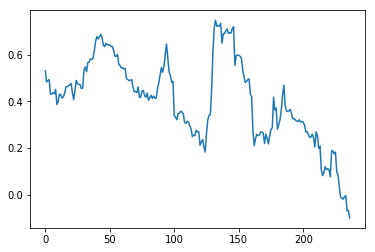

In [173]:
import matplotlib.pyplot as plt
plt.plot(m)

In [175]:
# 在险价值简介，PPT
# 下面代码计算在10天内持有50只股000001股票的在险价值
n_shares=50                      # input 1
confidence_level=0.99            # input 2
n_days=10                        # input 3
z=sp.stats.norm.ppf(confidence_level)
# 在99%置信水平下的分界点
ticker='000001.SZ'
start = '20170901'
end = '20181011'
p = pro.daily(ts_code = ticker, start_date = start, end_date = end)[['trade_date', 'close']]
s1=ret_f('000001.SZ',start,end)
position=n_shares * p.close[0]
VaR = position*z*np.std(s1)*np.sqrt(n_days)
print("Holding=",position, "VaR=", round(VaR,4), "in ", n_days, "Days")

Holding= 493.0 VaR= 79.4584 in  10 Days


In [176]:
# 这就表示，今天的股票价值是493元，未来10天在99%置信水平的在险价值为79.46元，其实风险挺大的

In [185]:
# 构建有效边界
#首先， 估计方差矩阵
ret=np.matrix(np.array([[0.1,0.2],[0.10,0.1071],[-0.02,0.25],[0.012,0.028],[0.06,0.262],[0.14,0.115]]))
# 假定一个收益矩阵
print('收益矩阵')
print(ret)

covar_=ret.T*ret
weight=np.matrix(np.array([0.4,0.6]))
# 设定两只股票分别的权重

print ("权重",weight)
print(weight*covar_*weight.T)

收益矩阵
[[ 0.1     0.2   ]
 [ 0.1     0.1071]
 [-0.02    0.25  ]
 [ 0.012   0.028 ]
 [ 0.06    0.262 ]
 [ 0.14    0.115 ]]
权重 [[0.4 0.6]]
[[0.10555915]]


In [189]:
# 其次，优化
from scipy.optimize import minimize
def y_f(x):
    return (3+2*x**2)
x0=100
res = minimize(y_f, x0, method='nelder-mead', options={'xtol':1e-8,'disp': True})
# method='nelder-mead'，options={'xtol':1e-8,'disp': True}这些都是统计上的参数，如果没有特殊要求，默认即可

print(res.x)

Optimization terminated successfully.
         Current function value: 3.000000
         Iterations: 37
         Function evaluations: 74
[0.]


In [ ]:
# 表示该函数最小值是3，当x取值为0时取得

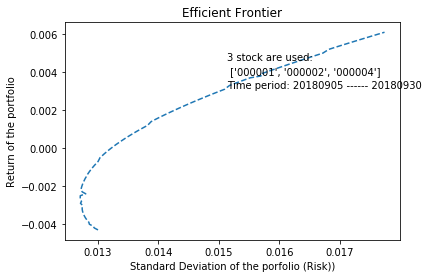

In [216]:
通过三只股票，构建一个有效边界
简单讲解一下，大部分都是公式的编写，这些都是不需要改动的，可以直接套用，需要绘制有效边界时，基本上可以更改下step1和2即可
# Step 1: input area
start = '20180905'
end = '20180930'
n_stock = 3
stocks = ['000001', '000002', '000004']

# Step 2: Generate a return matrix R
y = pd.DataFrame()
y['000001'] = ret_f('000001.SZ',start,end)
y['000002'] = ret_f('000002.SZ',start,end)
y['000004'] = ret_f('000004.SZ',start,end)
R = np.array(y)
    
def objFunction(W, R, target_ret): 
    stock_mean=np.mean(R,axis=0)
    port_mean=np.dot(W,stock_mean)           # portfolio mean
    cov=np.cov(R.T)                          # variance-covariance matrix
    port_var=np.dot(np.dot(W,cov),W.T)       # portfolio variance
    penalty = 2000*abs(port_mean-target_ret) # penalty for deviation from target
    return np.sqrt(port_var) + penalty       # objective function 

#Step 3:estimate optimal portfolo for a given return 
out_mean,out_std,out_weight=[],[],[] 
stockMean=np.mean(R,axis=0)    
for r in np.linspace(np.min(stockMean), np.max(stockMean), num=100):
    W = np.ones([n_stock])/n_stock                       # starting from equal weights 
    b_ = [(0,1) for i in range(n_stock)]              # bounds, here no short
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) # constraint
    result=sp.optimize.minimize(objFunction,W,(R,r),method='SLSQP',constraints=c_, bounds=b_)    
    if not result.success:                            # handle error
        raise BaseException(result.message) 
    out_mean.append(round(r,4))                       # not too many decimal places
    std_=round(np.std(np.sum(R*result.x,axis=1)),6)
    out_std.append(std_)
    out_weight.append(result.x) 
# Step 4: plot the efficient frontier
plt.title('Efficient Frontier')
plt.xlabel('Standard Deviation of the porfolio (Risk))')
plt.ylabel('Return of the portfolio')
plt.figtext(0.5,0.75,str(n_stock)+' stock are used: ')
plt.figtext(0.5,0.7,' '+str(stocks))
plt.figtext(0.5,0.65,'Time period: '+str(start)+' ------ '+str(end))
plt.plot(out_std,out_mean,'--')
plt.show()

In [ ]:
# 其实通过上面这个例子可以看出，基础函数是最重要的，看似一个很复杂的代码，但是里面都是基础的东西，只不过因为一些公式的复杂度，导致基础的东西
# 层层嵌套。看似复杂，其实最复杂的公式的东西都是不需要改动的，很多都可以直接套用，所以，那些最基础的一定要多练习

In [242]:
# 插值法简介
x=pd.Series([1,2,np.nan,np.nan,6])
# 假如想通过线性插值的方法填充缺失值，可以采用x.interpolate函数，但是注意，x必须是pands的格式(Series, Dataframe)
print(x.interpolate())

0    1.000000
1    2.000000
2    3.333333
3    4.666667
4    6.000000
dtype: float64


In [243]:
# 假如有一个债券的收益率数据，知道期限分别为2年，3年，5年，10年的债券收益率，通过线性插值算法，大致估算其他期限的收益率
x=pd.Series([0.29,0.57,np.nan,1.34,np.nan,np.nan,np.nan,np.nan,2.7])
y=x.interpolate()
print (y)

0    0.290
1    0.570
2    0.955
3    1.340
4    1.612
5    1.884
6    2.156
7    2.428
8    2.700
dtype: float64


In [261]:
# 输出数据
save = pd.DataFrame(np.random.rand(3, 2), columns=['a', 'b'])

In [262]:
save

,a,b
0,0.507904,0.991505
1,0.309264,0.808637
2,0.495715,0.422336


In [266]:
save.to_csv('sa.csv')
# 存储到csv文件中
save.to_excel('sa.xlsx')
# 存储到excel

In [ ]:
# 关于talib，技术分析用的一个包，安装过程可以百度一下
# 技术分析使用这个包可以省去很多步骤，比如计算macd，ma，布林线等

In [8]:
# 举个例子，计算一个股票的ROCR指标，其实是ROC的移动平均
# ROC(Price Rate of Change)又称变动率指标，今天的收盘价比较其N天前的收盘价的差除以N天前的收盘价（本质其实是N日K线的涨幅）
# 重置
import numpy as np
import pandas as pd
import talib as ta
from pyexcel_xls import get_data
# 对于读取多个子表格的excel时，这个模块很方便
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 忽略警告

In [2]:
# 读取文件
df1 = get_data('sz50.xlsx')
code = list(df1.keys())
# 因为这个excel中子表格很多，因此，通过get_data获取到excel对应的一个字典，字典的keys就是子表格名字，可以方便后期使用

In [6]:
data_dict = {}
for i in code:
    data = pd.read_excel('sz50.xlsx', sheetname=i, index_col= 'datetime')
    data_dict[i] = data.loc['2017-01-03': '2017-11-20']
PN = pd.Panel(data_dict)

data_rocr = PN.ix[:, :, 'close']

/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/pandas/core/panel.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  minor_axis=minor_ax

In [7]:
data_rocr

,600000.XSHG,600016.XSHG,600028.XSHG,600029.XSHG,600030.XSHG,600036.XSHG,600048.XSHG,600050.XSHG,600100.XSHG,600104.XSHG,...,601766.XSHG,601788.XSHG,601800.XSHG,601818.XSHG,601857.XSHG,601881.XSHG,601901.XSHG,601985.XSHG,601988.XSHG,601989.XSHG
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-03 15:00:00,115.99,135.93,10.94,11.64,61.83,69.31,170.27,8.99,210.96,141.29,...,11.21,18.74,17.97,5.03,10.10,NaN,7.96,7.20,5.42,12.32
2017-01-04 15:00:00,116.28,135.93,11.06,11.72,61.94,69.42,170.64,8.98,212.01,143.71,...,11.32,18.74,18.17,5.03,10.12,NaN,8.00,7.20,5.44,12.38
2017-01-05 15:00:00,116.07,135.63,11.42,11.80,61.64,69.85,170.08,9.48,210.80,142.17,...,11.28,18.68,18.12,5.03,10.34,NaN,7.94,7.15,5.44,12.54
2017-01-06 15:00:00,115.21,134.58,11.64,11.80,61.14,69.35,169.53,9.27,209.29,141.41,...,11.32,18.40,18.35,4.99,10.58,NaN,7.87,7.15,5.38,12.47
2017-01-09 15:00:00,115.35,134.73,11.64,11.85,61.41,69.23,169.90,9.31,210.65,142.88,...,11.54,18.45,18.52,4.98,10.59,NaN,7.89,7.29,5.39,13.02
2017-01-10 15:00:00,115.28,134.73,11.72,12.73,61.48,69.23,170.08,9.13,210.05,142.00,...,11.46,18.41,17.98,4.98,10.63,NaN,7.90,7.23,5.38,12.74
2017-01-11 15:00:00,115.07,134.14,11.44,12.13,61.52,69.27,169.16,8.34,207.33,141.17,...,11.35,18.33,18.14,4.97,10.54,NaN,7.74,7.21,5.39,12.84
2017-01-12 15:00:00,114.78,134.29,11.58,11.98,61.67,69.46,167.49,8.06,203.55,141.64,...,11.24,18.22,18.12,4.96,10.53,NaN,7.70,7.16,5.39,12.85
2017-01-13 15:00:00,115.85,135.48,11.68,11.97,61.94,70.27,168.23,8.03,201.89,142.82,...,11.29,18.26,18.15,4.99,10.62,NaN,7.73,7.18,5.42,12.62


In [9]:
#用talib计算50只股票的周期为5的ROCR100，生成Dataframe
rocr100_5 = pd.DataFrame()
data_rocr.dropna(how= 'all', axis = 1, inplace= True)
code = list(data_rocr)
for i in code:
    rocr100_5[i] = ta.ROCR100(data_rocr[i], 5)

print(rocr100_5)

                     600000.XSHG  600016.XSHG  600028.XSHG  600029.XSHG  \
datetime                                                                  
2017-01-03 15:00:00          NaN          NaN          NaN          NaN   
2017-01-04 15:00:00          NaN          NaN          NaN          NaN   
2017-01-05 15:00:00          NaN          NaN          NaN          NaN   
2017-01-06 15:00:00          NaN          NaN          NaN          NaN   
2017-01-09 15:00:00          NaN          NaN          NaN          NaN   
2017-01-10 15:00:00    99.387878    99.117193   107.129799   109.364261   
2017-01-11 15:00:00    98.959408    98.683146   103.435805   103.498294   
2017-01-12 15:00:00    98.888602    99.012018   101.401051   101.525424   
2017-01-13 15:00:00   100.555507   100.668747   100.343643   101.440678   
2017-01-16 15:00:00   102.228002   101.662584   101.718213   101.434599   
2017-01-17 15:00:00   101.361901   101.328583   101.535836    94.029851   
2017-01-18 15:00:00   102

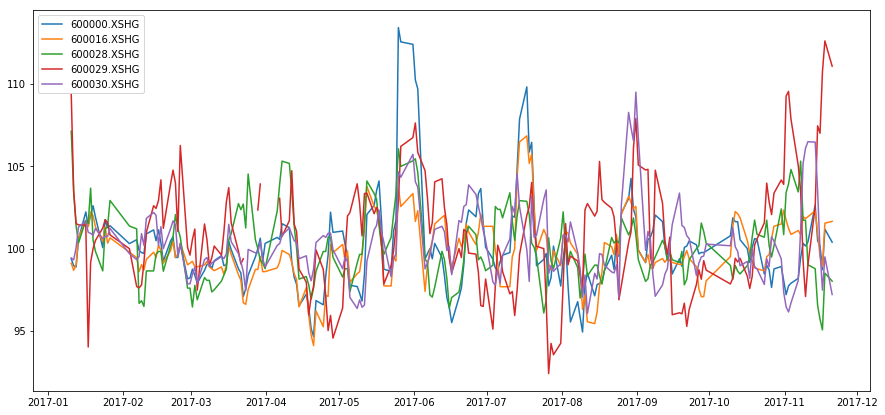

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(rocr100_5.ix[:, 0])
plt.plot(rocr100_5.ix[:, 1])
plt.plot(rocr100_5.ix[:, 2])
plt.plot(rocr100_5.ix[:, 3])
plt.plot(rocr100_5.ix[:, 4])
plt.legend(list(rocr100_5)[:5])
plt.show()